In [1]:
!pwd

/home/kei/Desktop/CausalKinetiX-Python/dev


In [2]:
import numbers
import numpy as np
from matplotlib import pyplot as plt
import os
os.chdir("/home/kei/Desktop/CausalKinetiX-Python/")
from CausalKinetiX import CausalKinetiX
from CausalKinetiX.CausalKinetiX_modelranking import CausalKinetiX_modelranking
from CausalKinetiX.constrained_smoothspline import constrained_smoothspline
from CausalKinetiX.generate_data_targetmodel import generate_data_targetmodel
from CausalKinetiX.generate_data_maillard import generate_data_maillard
from CausalKinetiX.generate_data_hidden import generate_data_hidden
from CausalKinetiX.ode_solver import ode_solver
from CausalKinetiX.utils import extend_Dmat
from sklearn.linear_model import LinearRegression

In [3]:
!ls

CausalKinetiX  dev  LICENCE  README.md	setup.py


In [4]:
!ls CausalKinetiX

BSbasis.py		       generate_data_hidden.py	     ode_solver.py
CausalKinetiX_modelranking.py  generate_data_maillard.py     __pycache__
CausalKinetiX.py	       generate_data_targetmodel.py  utils.py
constrained_smoothspline.py    __init__.py


# Target Model

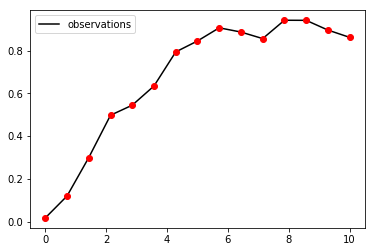

In [5]:
simulation_obj = generate_data_targetmodel(env=np.array(list(range(5))*3),
                                            L=15,
                                            d=5,
                                            noise_var=0.05)
D = simulation_obj["simulated_data"]
fulldata = simulation_obj["true_model"]
time = simulation_obj["time"]
env = simulation_obj["env"]
target = simulation_obj["target"]
# plot the observation of target variable in environment 0
plt.plot(time, D[0,-len(time):], '-',c="black")
plt.plot(time, D[0,-len(time):], 'o',c="red")
plt.legend(["observations"])


In [6]:
CausalKinetiX(D = D, times = time, env=env, target = target)

{'models': [[[0], [1], [2]],
  [[0], [1], [3]],
  [[0], [1], [4]],
  [[0], [2], [3]],
  [[0], [2], [4]],
  [[0], [3], [4]],
  [[1], [2], [3]],
  [[1], [2], [4]],
  [[1], [3], [4]],
  [[2], [3], [4]]],
 'model_scores': array([0.08882123, 0.08773881, 0.09710121, 1.34763329, 0.6399857 ,
        0.68248316, 0.31830627, 0.35090982, 0.36331057, 0.62929782]),
 'variable_scores': array([0.        , 0.        , 0.66666667, 0.66666667, 0.66666667]),
 'ranking': array([0, 1, 2, 3, 4])}

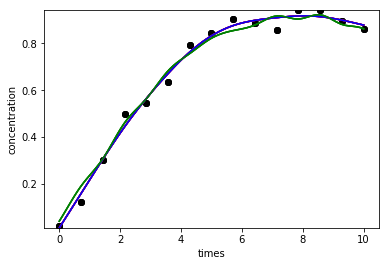

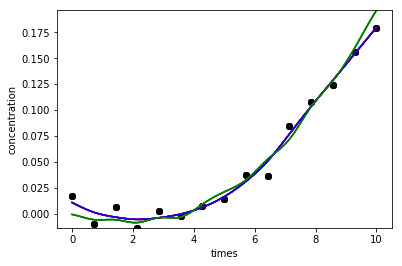

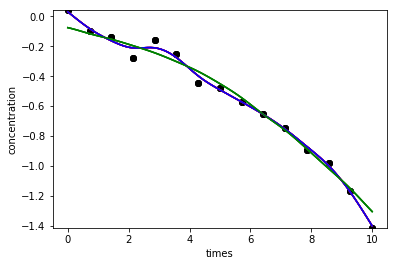

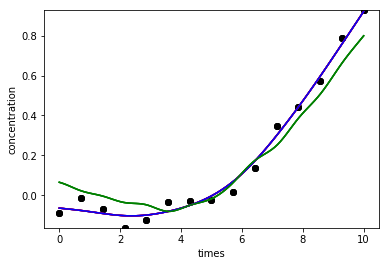

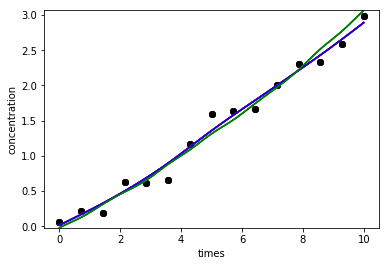

array([0.09379785])

In [7]:
CausalKinetiX_modelranking(D, time, env, target, [[[0],[1]]], 
                           include_vars=None, show_plot=True, 
                           integrated_model=False, score_type="mean2")#, regression_class='random_forest')

In [8]:
fit = constrained_smoothspline(D[1,60:],
                                          time,
                                          2,
                                          constraint="none",
                                          times_new=np.linspace(0,10,1001),
                                          num_folds=2,
                                          lambd="optim")

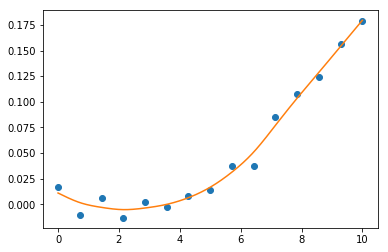

In [9]:
plt.plot(time, D[1,60:], 'o')
plt.plot(np.linspace(0,10,1001), fit["smooth_vals_new"])

# Maillard Model

Currently solving ODE-system on environment 0
Currently solving ODE-system on environment 1
Currently solving ODE-system on environment 2
Currently solving ODE-system on environment 3
Currently solving ODE-system on environment 4


[[0], [1], [0, 9]]

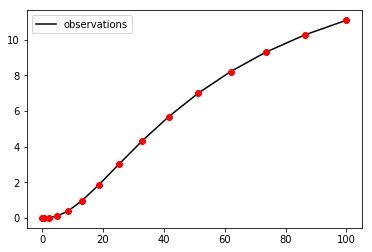

In [10]:
simulation_obj = generate_data_maillard(env=np.array(list(range(5))*3),
                                        L=15,
                                        target=0)
D = simulation_obj["simulated_data"]
time = simulation_obj["time"]
env = simulation_obj["env"]
target = simulation_obj["target"]
# plot the observation of target variable in environment 0
plt.plot(time, D[0,-len(time):], '-',c="black")
plt.plot(time, D[0,-len(time):], 'o',c="red")
plt.legend(["observations"])

simulation_obj["true_model"]

In [11]:
CausalKinetiX(D = D, times = time, env=env, target = target, interactions=True, products=True)

{'models': [[[0], [1], [2], [0, 1], [0, 2], [1, 2], [0, 0], [1, 1], [2, 2]],
  [[0], [1], [3], [0, 1], [0, 3], [1, 3], [0, 0], [1, 1], [3, 3]],
  [[0], [1], [4], [0, 1], [0, 4], [1, 4], [0, 0], [1, 1], [4, 4]],
  [[0], [1], [5], [0, 1], [0, 5], [1, 5], [0, 0], [1, 1], [5, 5]],
  [[0], [1], [6], [0, 1], [0, 6], [1, 6], [0, 0], [1, 1], [6, 6]],
  [[0], [1], [7], [0, 1], [0, 7], [1, 7], [0, 0], [1, 1], [7, 7]],
  [[0], [1], [8], [0, 1], [0, 8], [1, 8], [0, 0], [1, 1], [8, 8]],
  [[0], [1], [9], [0, 1], [0, 9], [1, 9], [0, 0], [1, 1], [9, 9]],
  [[0], [1], [10], [0, 1], [0, 10], [1, 10], [0, 0], [1, 1], [10, 10]],
  [[0], [2], [3], [0, 2], [0, 3], [2, 3], [0, 0], [2, 2], [3, 3]],
  [[0], [2], [4], [0, 2], [0, 4], [2, 4], [0, 0], [2, 2], [4, 4]],
  [[0], [2], [5], [0, 2], [0, 5], [2, 5], [0, 0], [2, 2], [5, 5]],
  [[0], [2], [6], [0, 2], [0, 6], [2, 6], [0, 0], [2, 2], [6, 6]],
  [[0], [2], [7], [0, 2], [0, 7], [2, 7], [0, 0], [2, 2], [7, 7]],
  [[0], [2], [8], [0, 2], [0, 8], [2, 8], [0, 0

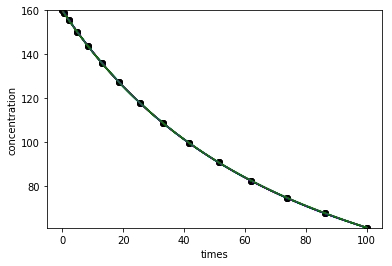

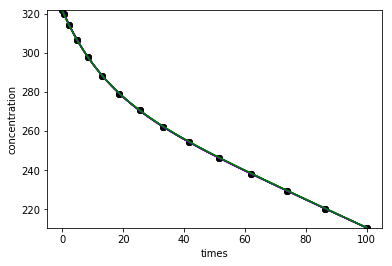

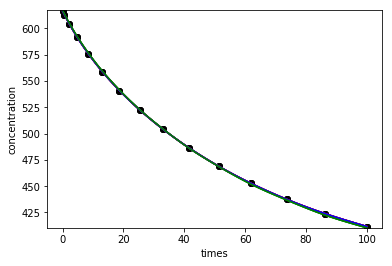

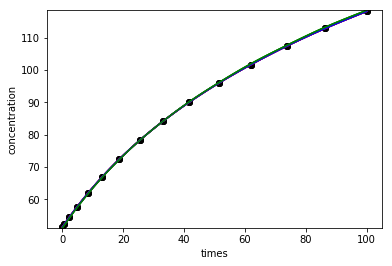

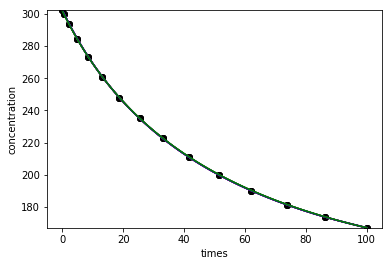

array([1.73608416])

In [12]:
CausalKinetiX_modelranking(D, time, env, target, 
                           [[[0], [1], [0, 9]]],
                           include_vars=None, show_plot=True, integrated_model=False , score_type="mean2")

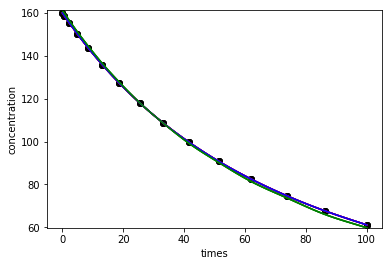

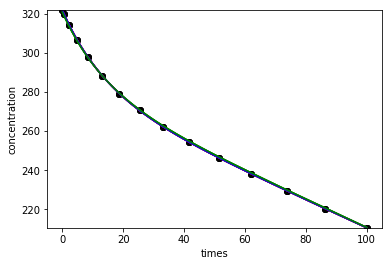

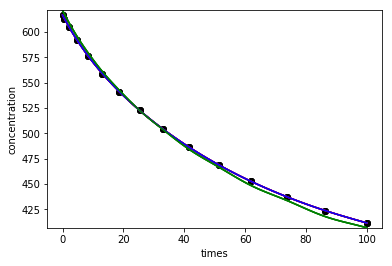

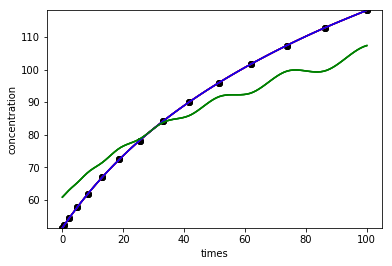

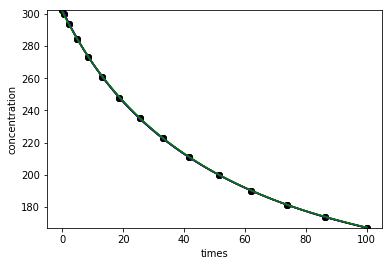

array([210.22096199])

In [13]:
CausalKinetiX_modelranking(D, time, env, target, 
                           [[[0], [1], [9], [0, 1], [0, 9], [1, 9], [0, 0], [1, 1], [9, 9]]],
                           include_vars=None, show_plot=True, integrated_model=False, score_type="mean2")

# Hidden Model

Currently solving ODE-system on environment 0
Currently solving ODE-system on environment 1
Currently solving ODE-system on environment 2
Currently solving ODE-system on environment 3
Currently solving ODE-system on environment 4


[[2]]

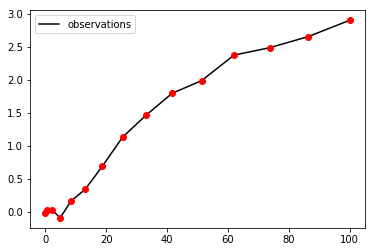

In [14]:
simulation_obj = generate_data_hidden(env=np.array(list(range(5))*3),
                                       L=15,
                                       noise=0.02,
                                       only_target_noise=False,
                                       relativ=True,
                                       intervention="initial_blockreactions5",
                                       intervention_par=0.2)
D = simulation_obj["simulated_data"]
time = simulation_obj["time"]
env = simulation_obj["env"]
target = simulation_obj["target"]
# plot the observation of target variable in environment 0
plt.plot(time, D[0,-len(time):], '-',c="black")
plt.plot(time, D[0,-len(time):], 'o',c="red")
plt.legend(["observations"])

simulation_obj["true_model"]

In [15]:
# the simulated_obj["true_model"] seems to be incorrect
# true model is [[0],[6]]
CausalKinetiX(D = D, times = time, env=env, target = target, expsize=1)

{'models': [[[0], [1]],
  [[0], [2]],
  [[0], [3]],
  [[0], [4]],
  [[0], [5]],
  [[0], [6]],
  [[1], [2]],
  [[1], [3]],
  [[1], [4]],
  [[1], [5]],
  [[1], [6]],
  [[2], [3]],
  [[2], [4]],
  [[2], [5]],
  [[2], [6]],
  [[3], [4]],
  [[3], [5]],
  [[3], [6]],
  [[4], [5]],
  [[4], [6]],
  [[5], [6]]],
 'model_scores': array([6.19073595, 1.92286859, 6.23028197, 3.54471693, 5.68714877,
        1.86958467, 1.24038112, 4.82586847, 3.53895195, 6.11526039,
        2.05404729, 1.90558488, 1.82734301, 0.38204151, 1.16144174,
        3.88565547, 3.96510134, 1.48206753, 2.30319836, 1.23107671,
        1.54643744]),
 'variable_scores': array([0.00167699, 0.03070175, 0.19840041, 0.57572239, 0.57572239,
        0.57572239, 0.90776574]),
 'ranking': array([6, 2, 5, 1, 3, 4, 0])}

# ODEFIT

Currently solving ODE-system on environment 0
Currently solving ODE-system on environment 1
Currently solving ODE-system on environment 2
Currently solving ODE-system on environment 3
Currently solving ODE-system on environment 4
target: 1
true_model: [[0], [1], [1, 9]]


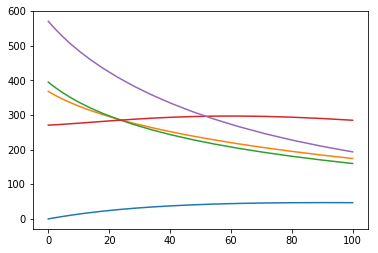

In [17]:
## Generate data from Maillard reaction
simulation_obj = generate_data_maillard(target=1, noise=0.5, noise_target=10,
                                         env=np.array(list(range(5))*3),
                                         L=20)
D = simulation_obj["simulated_data"]
time = simulation_obj["time"]
env = simulation_obj["env"]
target = simulation_obj["target"]
true_model = simulation_obj["true_model"]
print("target: {}\ntrue_model: {}".format(target, true_model))
for i in range(5):
    plt.plot(time, D[i, target*20:(target+1)*20])

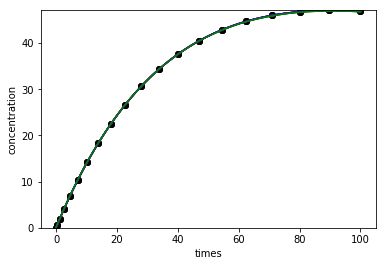

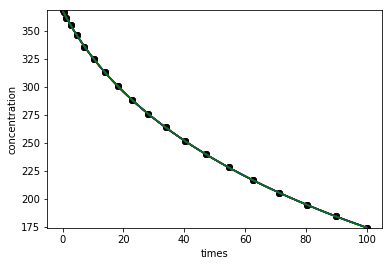

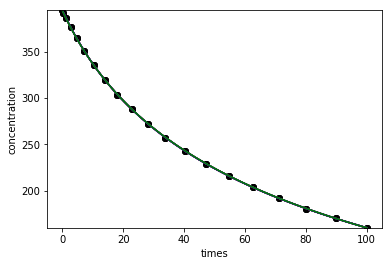

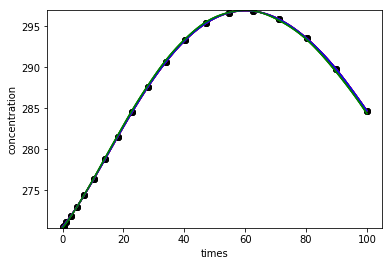

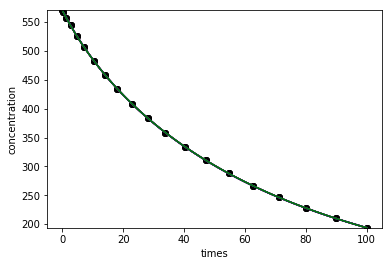

array([0.30161686])

In [18]:
CausalKinetiX_modelranking(D, time, env, target, [true_model],
                           include_vars=None, show_plot=True, score_type="mean2",integrated_model=False)

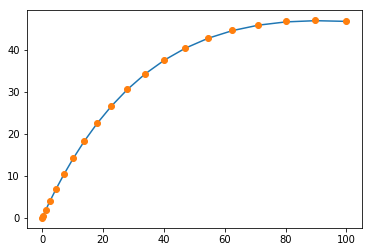

In [20]:
### Estimate dY (derivative) by spline
X = D[0:5,:].reshape([5, 11, len(time)])
X = X.swapaxes(0,1)
X = X.reshape([11, 5*len(time)]).T
times = np.array(list(time)*5)
dY = np.zeros([5*len(time)])
for j in range(5):
    dY[j*len(time):(j+1)*len(time)] = \
        constrained_smoothspline(X[j*len(time):(j+1)*len(time),target],
                                 time,
                                 2,
                                 constraint="none",
                                 times_new=time,
                                 num_folds=2,
                                 lambd="optim")["smooth_deriv"]

### Estimate coefficients based on true true_model
X_ = np.zeros([5*len(time), len(true_model)])
for term, i in zip(true_model, range(len(true_model))):
    tmp_col = 1
    for var in term: 
        tmp_col *= X[:,var]
    X_[:, i] = tmp_col
coef = LinearRegression(fit_intercept=False).fit(X_, dY).coef_

# coefficients of the maillard model with "target=0"
# theta=np.array([0.01, 0.00509, 0.00047, 0.0011, 0.00712, 0.00439, 0.00018, 0.11134, 0.14359, 0.00015, 0.12514])
# coef=[theta[0], -(theta[1]+theta[3]+theta[4]), -theta[9]]
# coef

## Solve for Melanoidin
odefit = ode_solver(time_vec=time, 
                    initial_value=X_[0,[target]], 
                    times=time, 
                    X=X[:len(time),:], 
                    model=true_model, 
                    target=target, 
                    coefs=coef)

# plot the 
plt.plot(odefit[:,0], odefit[:,1], '-')
plt.plot(time, X[:len(time),target], 'o')